# Clean Bibliography

To goal of this notebook is to clean your `.bib` file to ensure that it only contains the full first names of references that you have cited in your paper. The full first names will then be used to query the probabilistic gender classifier, [Gender API](https://gender-api.com). The full names will be used to query for probabilistic race using the [ethnicolr package](https://ethnicolr.readthedocs.io/).

The only required file you need is your manuscript's bibliography in `.bib` format. __Your `.bib` must only contain references cited in the manuscript__. Otherwise, the estimated proportions will be inaccurate.

If you intend to analyze the reference list of a published paper instead of your own manuscript in progress, search the paper on [Web of Knowledge](http://apps.webofknowledge.com/) (you will need institutional access). Next, [download the .bib file from Web of Science following these instructions, but start from Step 4 and on Step 6 select BibTeX instead of Plain Text](https://github.com/jdwor/gendercitation/blob/master/Step0_PullingWOSdata.pdf).

If you are not using LaTeX, collect and organize only the references you have cited in your manuscript using your reference manager of choice (e.g. Mendeley, Zotero, EndNote, ReadCube, etc.) and export that selected bibliography as a `.bib` file. __Please try to export your .bib in an output style that uses full first names (rather than only first initials) and using the full author lists (rather than abbreviated author lists with "et al.").__ If first initials are included, our code will automatically retrieve about 70% of those names using the article title or DOI. 

   * [Export `.bib` from Mendeley](https://blog.mendeley.com/2011/10/25/howto-use-mendeley-to-create-citations-using-latex-and-bibtex/)
   * [Export `.bib` from Zotero](https://libguides.mit.edu/ld.php?content_id=34248570)
   * [Export `.bib` from EndNote](https://www.reed.edu/cis/help/LaTeX/EndNote.html). Note: Please export full first names by either [choosing an output style that does so by default (e.g. in MLA style)](https://canterbury.libguides.com/endnote/basics-output) or by [customizing an output style.](http://bibliotek.usn.no/cite-and-write/endnote/how-to-use/how-to-show-the-author-s-full-name-in-the-reference-list-article185897-28181.html)
   * [Export `.bib` from Read Cube Papers](https://support.papersapp.com/support/solutions/articles/30000024634-how-can-i-export-references-from-readcube-papers-)

For those working in LaTeX, we can use an optional `.aux` file to automatically filter your `.bib` to check that it only contains entries which are cited in your manuscript.

| Input                 | Output                                                                                                                        |
|-----------------------|-------------------------------------------------------------------------------------------------------------------------------|
| `.bib` file(s)**(REQUIRED)**    | `cleanBib.csv`: table of author first names, titles, and .bib keys                                                            |
| `.aux` file (OPTIONAL)| `predictions.csv`: table of author first names, estimated gender classification, and confidence                                   |
| `.tex` file (OPTIONAL) | `race_gender_citations.pdf`: heat map of your citations broken down by probabilistic gender and race estimations
|                       | `yourTexFile_gendercolor.tex`: your `.tex` file modified to compile .pdf with in-line citations colored-coded by gender pairs |

## 1. Import functions

Upload your `.bib` file(s) and _optionally_ an `.aux` file generated from compiling your LaTeX manuscript and your `.tex` file

![upload button](img/upload.png)

![confirm upload button](img/confirmUpload.png)

Then, run the code block below. (click to select the block and then press Ctrl+Enter; or click the block and press the Run button in the top menubar)

In [2]:
import glob
from habanero import Crossref
import sys
import os
from pathlib import Path
wd = Path(os.getcwd())
#sys.path.insert(1, f'{wd.absolute()}/utils')
from preprocessing import *
from ethnicolr import pred_fl_reg_name
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
#np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

cr = Crossref()
homedir = '' #'/home/jovyan/'
bib_files = glob.glob(homedir + '*.bib')
paper_aux_file = glob.glob(homedir + '*.aux')
paper_bib_file = 'library_paper.bib'
try:
    tex_file = glob.glob(homedir + "*.tex")[0]
except:
    print('No optional .tex file found.')

2024-08-16 02:03:10.005828: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-16 02:03:10.049943: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 02:03:10.049965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 02:03:10.051263: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-16 02:03:10.058655: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-16 02:03:10.059516: I tensorflow/core/platform/cpu_feature_guard.cc:1

No optional .tex file found.


### 2. Define the _first_ and _last_ author of your paper.

For example: 
```
yourFirstAuthor = 'Teich, Erin G.'
yourLastAuthor = 'Bassett, Danielle S.'
```

And optionally, define any co-first or co-last author(s), making sure to keep the square brackets to define a list.

For example:
```
optionalEqualContributors = ['Dworkin, Jordan', 'Stiso, Jennifer']
```

or 

```
optionalEqualContributors = ['Dworkin, Jordan']
```

If you are analyzing published papers' reference lists from Web of Science, change the variable checkingPublishedArticle to True:
```
checkingPublishedArticle = True
```

Then, run the code block below. (click to select the block and then press Ctrl+Enter; or click the block and press the Run button in the top menubar)

__NOTE__: Please edit your .bib file using information printed by the code and provided in cleanedBib.csv. Edit directly within the Binder environment by clicking the .bib file (as shown below), making modifications, and saving the file (as shown below).

![open button](img/openBib.png)

![save button](img/saveBib.png)

Common issues include:

* Bibliography entry did not include a last author because the author list was truncated by "and Others" or "et al."
* Some older journals articles only provide first initial and not full first names, in which case you will need to go digging via Google to identify that person.
* In rare cases where the author cannot be identified even after searching by hand, replace the first name with "UNKNOWNNAMES" so that the classifier will estimate the gender as unknown.
* Make sure groups aren't used as first or last authors

In [5]:
yourFirstAuthor = 'Taube, Juliana'
yourLastAuthor = 'Bansal, Shweta'
optionalEqualContributors = ['Merritt, Alexes']
checkingPublishedArticle = False

if paper_aux_file:
    find_unused_cites(paper_aux_file)

# parses bib file
bib_data = get_bib_data(bib_files[0])
if checkingPublishedArticle:
    get_names_published(homedir, bib_data, cr)
else:
    # find and print duplicates
    bib_data = get_duplicates(bib_data, bib_files[0])
    # get names, remove CDS, find self cites
    get_names(homedir, bib_data, yourFirstAuthor, yourLastAuthor, optionalEqualContributors, cr)
    
bib_check(homedir)
# make sure to change people who have initials then name to just name
# also doesn't like accents, so need to remove those, could probably make a regex to replace {\.letter} with letter

1: salomon_us_2021
2: viboud_synchrony_2006
3: pasek_anesrake_2018
4: ingram_2013_2014
5: favier_influence_2005
6: susswein_ignoring_2021  <-- self-citation
7: truelove_characterizing_2019
8: feehan_quantifying_2021
9: gimma_changes_2022
10: coletti_comix_2020
11: cmmid_covid-19_working_group_quantifying_2020
12: chin_contact_2021
13: nelson_nationally_2022
14: tiu_characterizing_2022  <-- self-citation
15: breen_novel_2022
16: mousa_social_2021
17: mossong_social_2008
18: rohani_contact_2010
19: kucharski_contribution_2014
20: zagheni_using_2008
21: feehan_using_2019
22: dorelien_analyzing_2021
23: susswein_disentangling_2023  <-- self-citation
24: mistry_inferring_2021
25: eames_impact_2010
26: bansal_comparative_2006  <-- self-citation
27: salathe_dynamics_2010
28: rushmore_network-based_2014
29: kummer_evaluating_2022
30: read_social_2014
31: kiti_quantifying_2014
32: lofgren_influenza_2007
33: tamerius_global_2011
34: kleynhans_cross-sectional_2021
35: wood_generalized_2017
36: ba

## 3. Estimate gender and race of authors from cleaned bibliography

### Checkpoint for cleaned bibliography and using Gender API to estimate genders and race by names
After registering for a [gender-api](https://gender-api.com/) account (free), use your 500 free monthly search credits by __pasting your API key in the code for the line indicated below__ (replace only YOUR ACCOUNT KEY HERE):

```genderAPI_key = '&key=YOUR ACCOUNT KEY HERE'```

[You can find your key in your account's profile page.](https://gender-api.com/en/account/overview#my-api-key)

Then, run the code blocks below to estimate how many credits we will need to use. (click to select the block and then press Ctrl+Enter; or click the block and press the Run button in the top menubar)

In [6]:
# moot because we are using different gender prediction software
genderAPI_key = '&key=YOUR ACCOUNT KEY HERE'

# # Check your credit balance
check_genderAPI_balance(genderAPI_key, homedir)

Remaining credits: 455
This should use (at most) 100 credits, saving you approx 10 credit(s) by storing queries.


## 4. Describe the proportions of genders in your reference list and compare it to published base rates in neuroscience.

__NOTE__: your free GenderAPI account has 500 queries per month. This box contains the code that will use your limited API credits/queries if it runs without error. Re-running all code repeatedly will repeatedly use these credits.

Run the code blocks below. (click to select the block and then press Ctrl+Enter; or click the block and press the Run button in the top menubar)

In [7]:
mm, wm, mw, ww, WW, aw, wa, aa, citation_matrix, paper_df = get_pred_demos((yourFirstAuthor+' '+yourLastAuthor).replace(',',''), homedir, bib_data, gender_threshold = 0.7)


first author is Juliana Taube 
last author is Shweta Bansal 
we don't count these, but check the predictions file to ensure your names did not slip through!
looping through your references, predicting gender and race
110


TypeError: cannot unpack non-iterable NoneType object

In [5]:
#statement, statementLatex = print_statements(mm, wm, mw, ww, WW, aw, wa, aa)
# ignoring this right now

AttributeError: 'numpy.float64' object has no attribute 'values'

## 5. Print the Diversity Statement and visualize your results

The example template can be copied and pasted into your manuscript. We have included it in our methods or references section. If you are using LaTeX, [the bibliography file can be found here](https://github.com/dalejn/cleanBib/blob/master/diversityStatement/).

### Additional info about the neuroscience benchmark
For the top 5 neuroscience journals (Nature Neuroscience, Neuron, Brain, Journal of Neuroscience, and Neuroimage), the expected gender proportions in reference lists as reported by [Dworkin et al.](https://www.biorxiv.org/content/10.1101/2020.01.03.894378v1.full.pdf) are 58.4% for man/man, 9.4% for man/woman, 25.5% for woman/man, and 6.7% for woman/woman. Expected proportions were calculated by randomly sampling papers from 28,505 articles in the 5 journals, estimating gender breakdowns using probabilistic name classification tools, and regressing for relevant article variables like publication date, journal, number of authors, review article or not, and first-/last-author seniority. See [Dworkin et al.](https://www.biorxiv.org/content/10.1101/2020.01.03.894378v1.full.pdf) for more details. 

Using a similar random draw model regressing for relevant variables, the expected race proportions in reference lists as reported by Bertolero et al. were 51.8% for white/white, 12.8% for white/author-of-color, 23.5% for author-of-color/white, and 11.9% for author-of-color/author-of-color. 

This box does NOT contain code that will use your limited API credits/queries.

Run the code block below. (click to select the block and then press Ctrl+Enter; or click the block and press the Run button in the top menubar)

/home/a7a1ec6b-7fff-4e65-99fe-e5ea87baf016/queries.py:422: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_for_baserate_plot['baserate'] = baserate


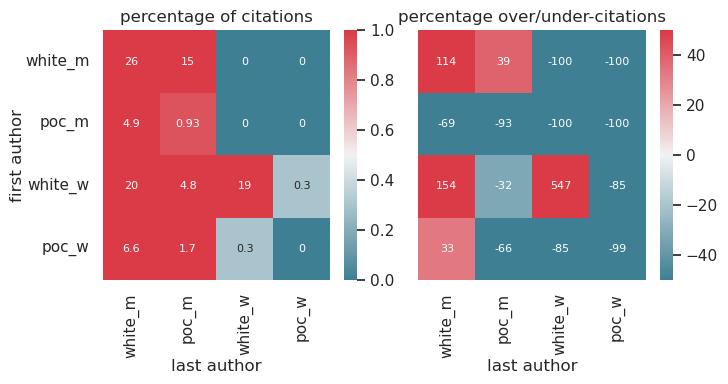

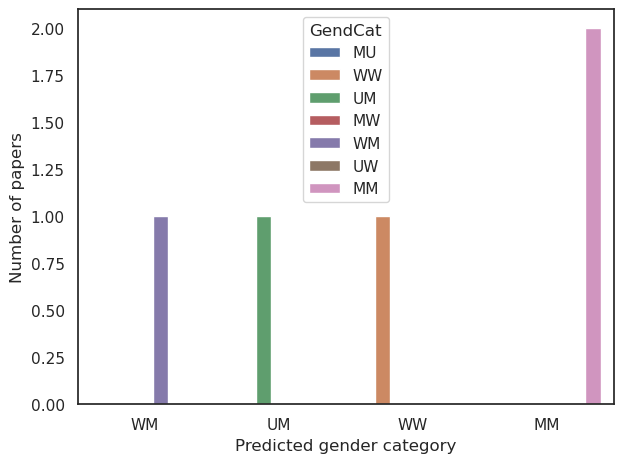

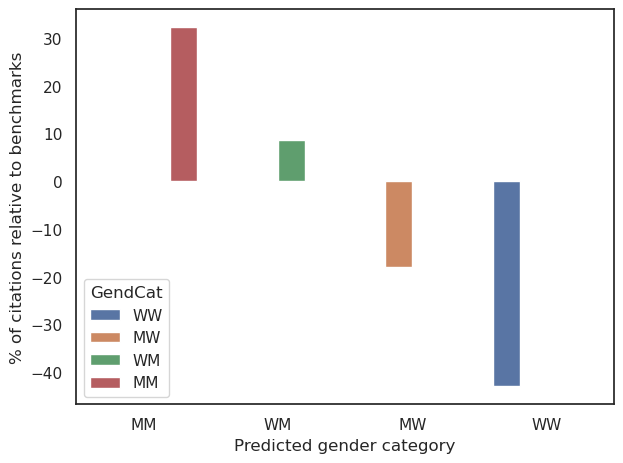

In [7]:
# print('Plain text template:')
# print(statement)
# print('\n')
# print('LaTeX template:')
# print(statementLatex)

paper_df.to_csv('predictions.csv')

plot_heatmaps(citation_matrix, homedir)

plot_gender_histograms()

### (OPTIONAL) Color-code your .tex file using the estimated gender classifications

Running this code-block will optionally output your uploaded `.tex` file with color-coding for gender pair classifications. You can find the [example below's pre-print here.](https://www.biorxiv.org/content/10.1101/664250v1)

![Color-coded .tex file, Eli Cornblath](img/texColors.png)

In [ ]:
colorful_latex(paper_df, homedir, tex_file, bib_data)